# Predict on new data using a trained CNN on XPS data on Google Colab

In this notebook, we will use a trained convolutional network to predict on unseen iron XPS spectra.

## Setup

### Mount google drive, change working directory

In [1]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Change working path
os.chdir('/content/drive/My Drive/app')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Install packages and import modules

In [2]:
# Install packages
!pip install python-docx

# Import standard modules and magic commands
import datetime
import numpy as np
import pytz
import importlib
import matplotlib.pyplot as plt

# Magic commands
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

     |████████████████████████████████| 5.5MB 4.3MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.10-cp36-none-any.whl size=184491 sha256=b5d1f1d4ef20493c60165a889e82e60df50d969dd0b5b8c121455b097e6a2738
  Stored in directory: /root/.cache/pip/wheels/18/0b/a0/1dd62ff812c857c9e487f27d80d53d2b40531bec1acecfa47b
Successfully built python-docx


## Predict on new data set

### Load custom modules

In [3]:
try:
    import importlib
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('\n Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as clfutils
    print('\n Modules were loaded.')


 Modules were loaded.


### Set up the parameters & folder structure

In [4]:
np.random.seed(502)
time = datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin')).strftime("%Y%m%d_%Hh%Mm")
data_name = 'Fe_multiple_4_classes_measured_predict_using_20200727_12h31m'

label_values = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']

clf = classifier.ClassifierMultiple(time = time,
                                    data_name = data_name,
                                    labels = label_values)

Model folder created at /saved_models/20200730_12h05m_Fe_multiple_4_classes_measured_predict_using_20200727_12h31m
Logs folder created at /logs/20200730_12h05m_Fe_multiple_4_classes_measured_predict_using_20200727_12h31m
Figures folder created at /figures/20200730_12h05m_Fe_multiple_4_classes_measured_predict_using_20200727_12h31m


### Load and inspect the data

Data was loaded!
Total no. of samples: 156
No. of training samples: 1
No. of validation samples: 0
No. of test samples: 155
Shape of each sample : 1121 features (X) + 4 labels (y)


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


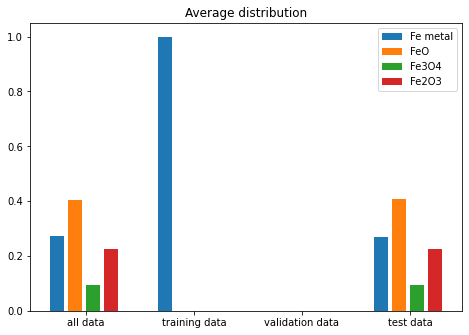

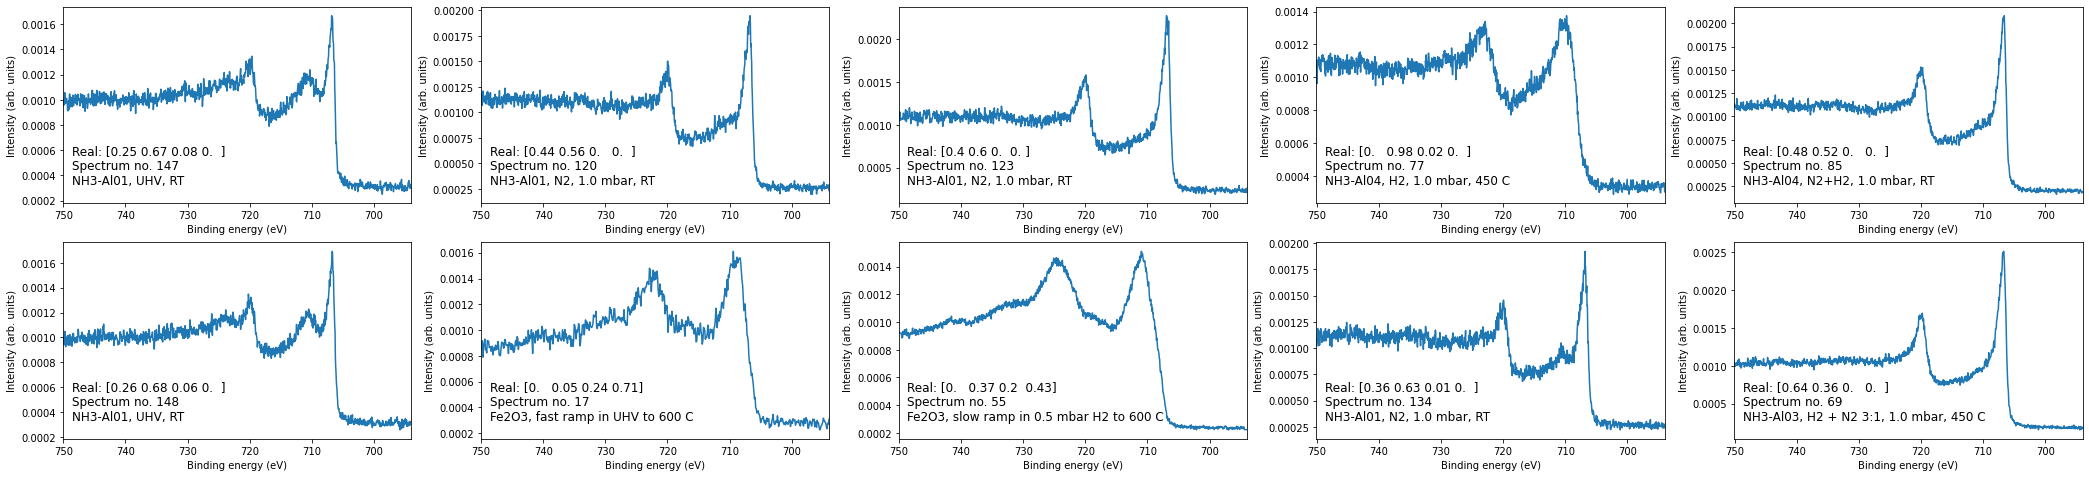

In [5]:
input_filepath = r'/content/drive/My Drive/app/datasets/measured.h5'
train_test_split = 0.99
train_val_split = 0
no_of_examples = 156

# =============================================================================
# X_train, X_val, X_test, y_train, y_val, y_test,\
#     aug_values_train, aug_values_val, aug_values_test =\
#         clf.load_data_preprocess(input_filepath = input_filepath,
#                                  no_of_examples = no_of_examples,
#                                  train_test_split = train_test_split,
#                                  train_val_split = train_val_split, 
#                                  augmentation_values = True)
# =============================================================================
        
X_train, X_val, X_test, y_train, y_val, y_test,\
    names_train, names_val, names_test =\
        clf.load_data_preprocess(input_filepath = input_filepath,
                                 no_of_examples = no_of_examples,
                                 train_test_split = train_test_split,
                                 train_val_split = train_val_split, 
                                 names = True)
        
# Check how the examples are distributed across the classes.
class_distribution = clf.check_class_distribution()
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 10, dataset = 'test')  

### Load the model

In [6]:
clf.load_model(model_path = '/content/drive/My Drive/app/saved_models/20200727_12h31m_Fe_multiple_4_classes_variable_linear_comb_no_broadening_combined_data')

Loaded model from disk.


### Compile and summarize the model

Model: "Loaded_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1121, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1121, 12)     72          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1121, 12)     132         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1121, 12)     192         input_1[0][0]                    
_______________________________________________________________________________________

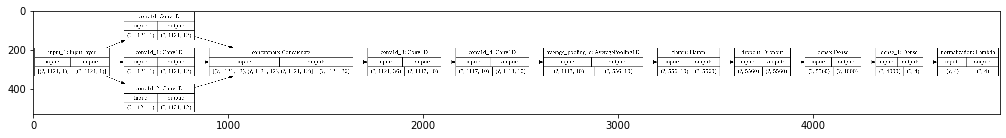

In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

learning_rate = 1e-05
optimizer = Adam(learning_rate = learning_rate) 
mse = MeanSquaredError()
mae = MeanAbsoluteError()
# =============================================================================
# def custom_loss(y_true, y_pred):
#     """
#     Custom loss for linear combination of XPS spectra.
#     """
#     squared_difference = tf.square(tf.subtract(y_true,y_pred))
#     squared_output = tf.square(y_pred)
#     
#     return tf.reduce_sum(tf.multiply(squared_output,squared_difference))
# =============================================================================

# Compile model with build-in loss function
#clf.model.compile(loss = mse, optimizer = optimizer)
clf.model.compile(loss = mae, optimizer = optimizer)

# Plot summary and save model plot.
clf.summary()
clf.save_and_print_model_image()

### Evaluate on test data

In [8]:
clf.batch_size = 32
test_loss = clf.evaluate()
print('Test loss: ' + str(test_loss))

5/5 [==============================] - 0s 56ms/step - loss: 0.1861
Evaluation done! 

Test loss: 0.18612639605998993


###  Predict on train & test data

In [9]:
pred_train, pred_test = clf.predict()

5/5 [==============================] - 0s 57ms/step
Prediction done!


### Show some predictions on random test samples

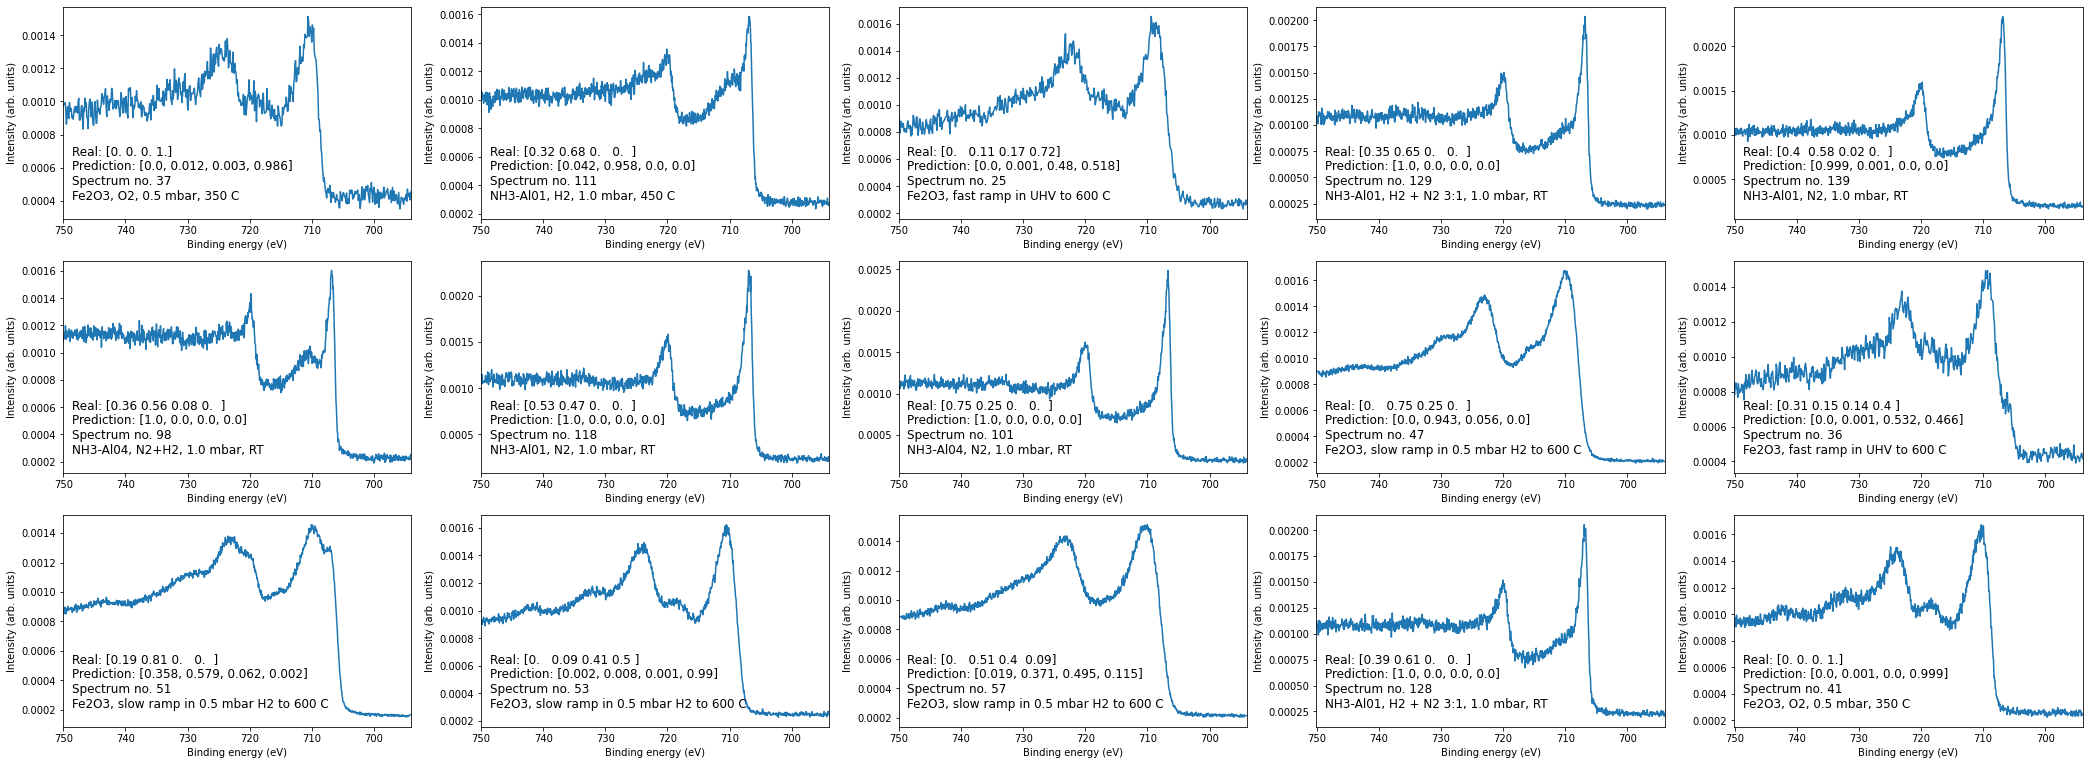

In [10]:
clf.plot_random(no_of_spectra = 15, dataset = 'test', with_prediction = True)  


### Show the worst predictions on the test samples

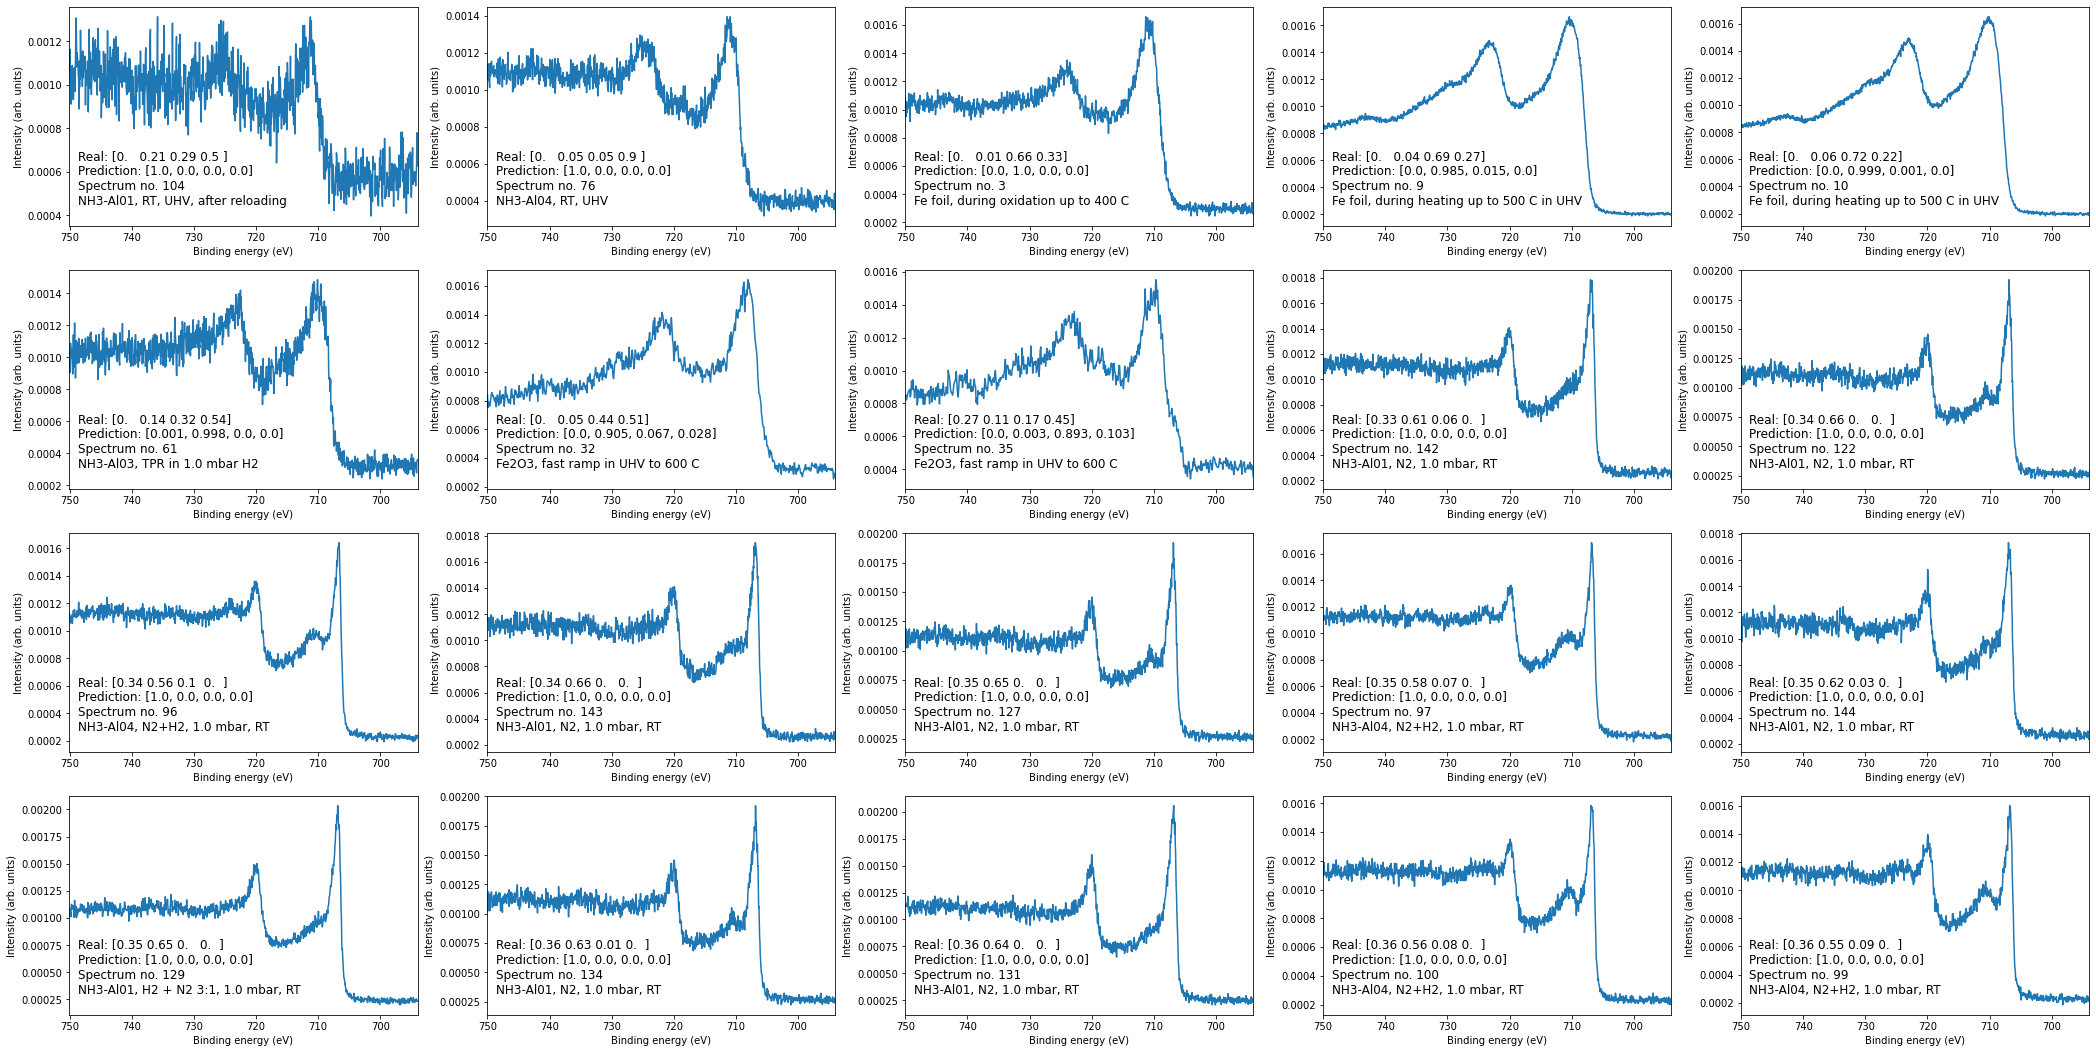

In [11]:
clf.show_worst_predictions(no_of_spectra = 20)

### Save data

In [12]:
clf.save_hyperparams()
clf.shelve_results(full = False)

Saved hyperparameters to file.
Saved results to file.


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


## Check where and why the predictions fail

### Calculate loss for each example in the test set

In [13]:
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()
mape = tf.keras.losses.MeanAbsolutePercentageError()

mse_losses = [mse(clf.y_test[i], clf.pred_test[i]).numpy() \
                  for i in range(clf.y_test.shape[0])]
mae_losses = [mae(clf.y_test[i], clf.pred_test[i]).numpy() \
                  for i in range(clf.y_test.shape[0])]
mape_losses = [mape(clf.y_test[i], clf.pred_test[i]).numpy() \
                  for i in range(clf.y_test.shape[0])]

In [62]:
def show_worst_of_one_kind(indices, spectra = [0,20]):
    if len(indices) > 0:
        no_of_spectra =  spectra[1] - spectra[0]
      
        no_of_cols = 5
        no_of_rows = int(no_of_spectra/no_of_cols)
        if (no_of_spectra % no_of_cols) != 0:
            no_of_rows += 1

        fig, axs = plt.subplots(nrows = no_of_rows, ncols = no_of_cols)
        plt.subplots_adjust(left = 0.125, bottom = 0.5,
                            right=4.8, top = no_of_rows,
                            wspace = 0.2, hspace = 0.2)                    
    
        for i in range(no_of_spectra):
            index = indices[spectra[0]+i]
            x = np.arange(694, 750.05, 0.05)
            y = clf.X_test[index]
            label = str(np.around(clf.y_test[index], decimals = 3))
            full_text = 'Real: ' +  label + '\n'
             
            tmp_array = np.around(clf.pred_test[index], decimals = 3) 
            full_text += 'Prediction: ' + str(list(tmp_array)) + '\n'
            try:
                full_text += clf._write_aug_text(dataset = 'test',
                                                 index = index)
            except AttributeError:
                pass
            try:
                full_text += clf._write_measured_text(dataset = 'test',
                                                      index = index)
            except AttributeError:
                 pass
            loss_text = ('MSE: ' + str(np.around(mse_losses[index], decimals = 3)) + ', ' +\
                         'MAE: ' + str(np.around(mae_losses[index], decimals = 3)))
         
            row, col = int(i/no_of_cols), i % no_of_cols
            try:
                axs[row, col].plot(np.flip(x),y)
                axs[row, col].invert_xaxis()
                axs[row, col].set_xlim(750.05,694)
                axs[row, col].set_xlabel('Binding energy (eV)')
                axs[row, col].set_ylabel('Intensity (arb. units)')                          
                axs[row, col].text(0.025, 0.4, full_text + loss_text,
                                   horizontalalignment='left',
                                   verticalalignment='top',
                                   transform = axs[row, col].transAxes,
                                   fontsize = 11.5) 
            except IndexError:
                axs[row].plot(np.flip(x),y)
                axs[row].invert_xaxis()
                axs[row].set_xlim(750.05,694)
                axs[row].set_xlabel('Binding energy (eV)')
                axs[row].set_ylabel('Intensity (arb. units)')                          
                axs[row].text(0.025, 0.4, full_text + loss_text,
                              horizontalalignment='left',
                              verticalalignment='top',
                              transform = axs[row].transAxes,
                              fontsize = 11.5) 
    else:
      pass

### Show worst predictions for single iron spectra

IndexError: ignored

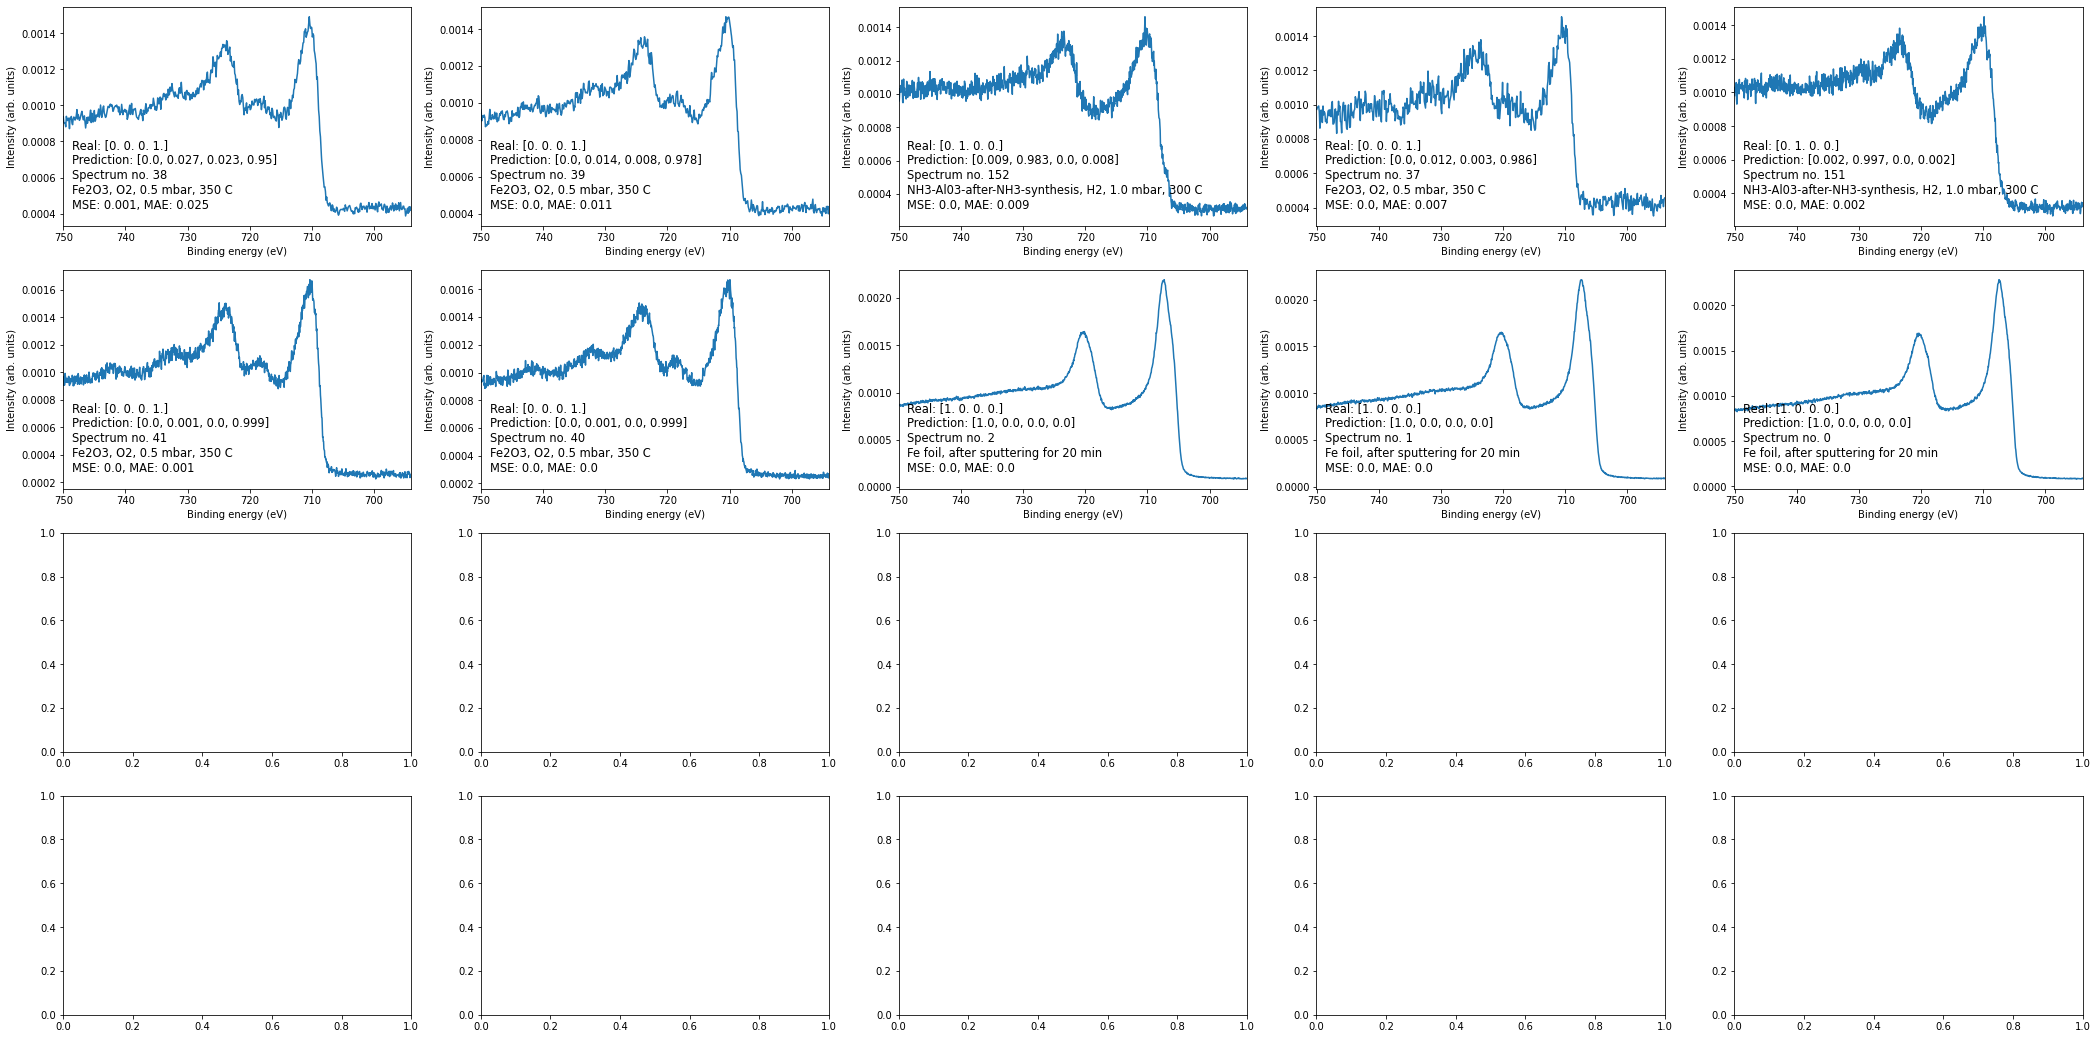

In [88]:
worst_indices_single = [j[1] for j in sorted([(x,i) for (i,x) in \
                                        enumerate(mae_losses) if len(np.where(clf.y_test[i] == 0.)[0]) == 3],
                                        reverse=True)] 
show_worst_of_one_kind(worst_indices_single, spectra = [0,20])

### Show worst predictions for different loss thresholds (single iron spectra)


In [ ]:
threshold = 0.2
worst_indices_single_01 = [j[1] for j in sorted([(x,i) for (i,x) in \
                           enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) == 3 and x >= threshold)],
                           reverse=True)]
  
show_worst_of_one_kind(worst_indices_single_01,
                       spectra = [len(worst_indices_single_01)-10,
                                  len(worst_indices_single_01)])

print('{0} of {1} test samples with single iron species ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_single_01)),
    str(len(worst_indices_single)),
    str(100*(np.around(len(worst_indices_single_01)/len(worst_indices_single), decimals = 3))),
    str(threshold)))

In [ ]:
threshold = 0.1
worst_indices_single_02 = [j[1] for j in sorted([(x,i) for (i,x) in \
                        enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) == 3 and x >= threshold)],
                        reverse=True)]

show_worst_of_one_kind(worst_indices_single_02,
                       spectra = [len(worst_indices_single_02)-10,
                                  len(worst_indices_single_02)])

print('{0} of {1} test samples with single iron species ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_single_02)),
    str(len(worst_indices_single)),
    str(100*(np.around(len(worst_indices_single_02)/len(worst_indices_single), decimals = 3))),
    str(threshold)))

In [ ]:
threshold = 0.05
worst_indices_single_03 = [j[1] for j in sorted([(x,i) for (i,x) in \
                        enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) == 3 and x >= threshold)],
                        reverse=True)]

show_worst_of_one_kind(worst_indices_single_03,
                       spectra = [len(worst_indices_single_03)-10,
                                  len(worst_indices_single_03)])

print('{0} of {1} test samples with single iron species ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_single_03)),
    str(len(worst_indices_single)),
    str(100*(np.around(len(worst_indices_single_03)/len(worst_indices_single), decimals = 3))),
    str(threshold)))

In [ ]:
threshold = 0.02
worst_indices_single_04 = [j[1] for j in sorted([(x,i) for (i,x) in \
                        enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) == 3 and x >= threshold)],
                        reverse=True)]

show_worst_of_one_kind(worst_indices_single_04,
                       spectra = [len(worst_indices_single_04)-10,
                                  len(worst_indices_single_04)])

print('{0} of {1} test samples with single iron species ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_single_04)),
    str(len(worst_indices_single)),
    str(100*(np.around(len(worst_indices_single_04)/len(worst_indices_single), decimals = 3))),
    str(threshold)))

In [ ]:
threshold = 0.01
worst_indices_single_05 = [j[1] for j in sorted([(x,i) for (i,x) in \
                        enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) == 3 and x >= threshold)],
                        reverse=True)]

show_worst_of_one_kind(worst_indices_single_05,
                       spectra = [len(worst_indices_single_05)-10,
                                  len(worst_indices_single_05)])

print('{0} of {1} test samples with single iron species ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_single_05)),
    str(len(worst_indices_single)),
    str(100*(np.around(len(worst_indices_single_05)/len(worst_indices_single), decimals = 3))),
    str(threshold)))

### Show worst predictions for linearly combined iron spectra

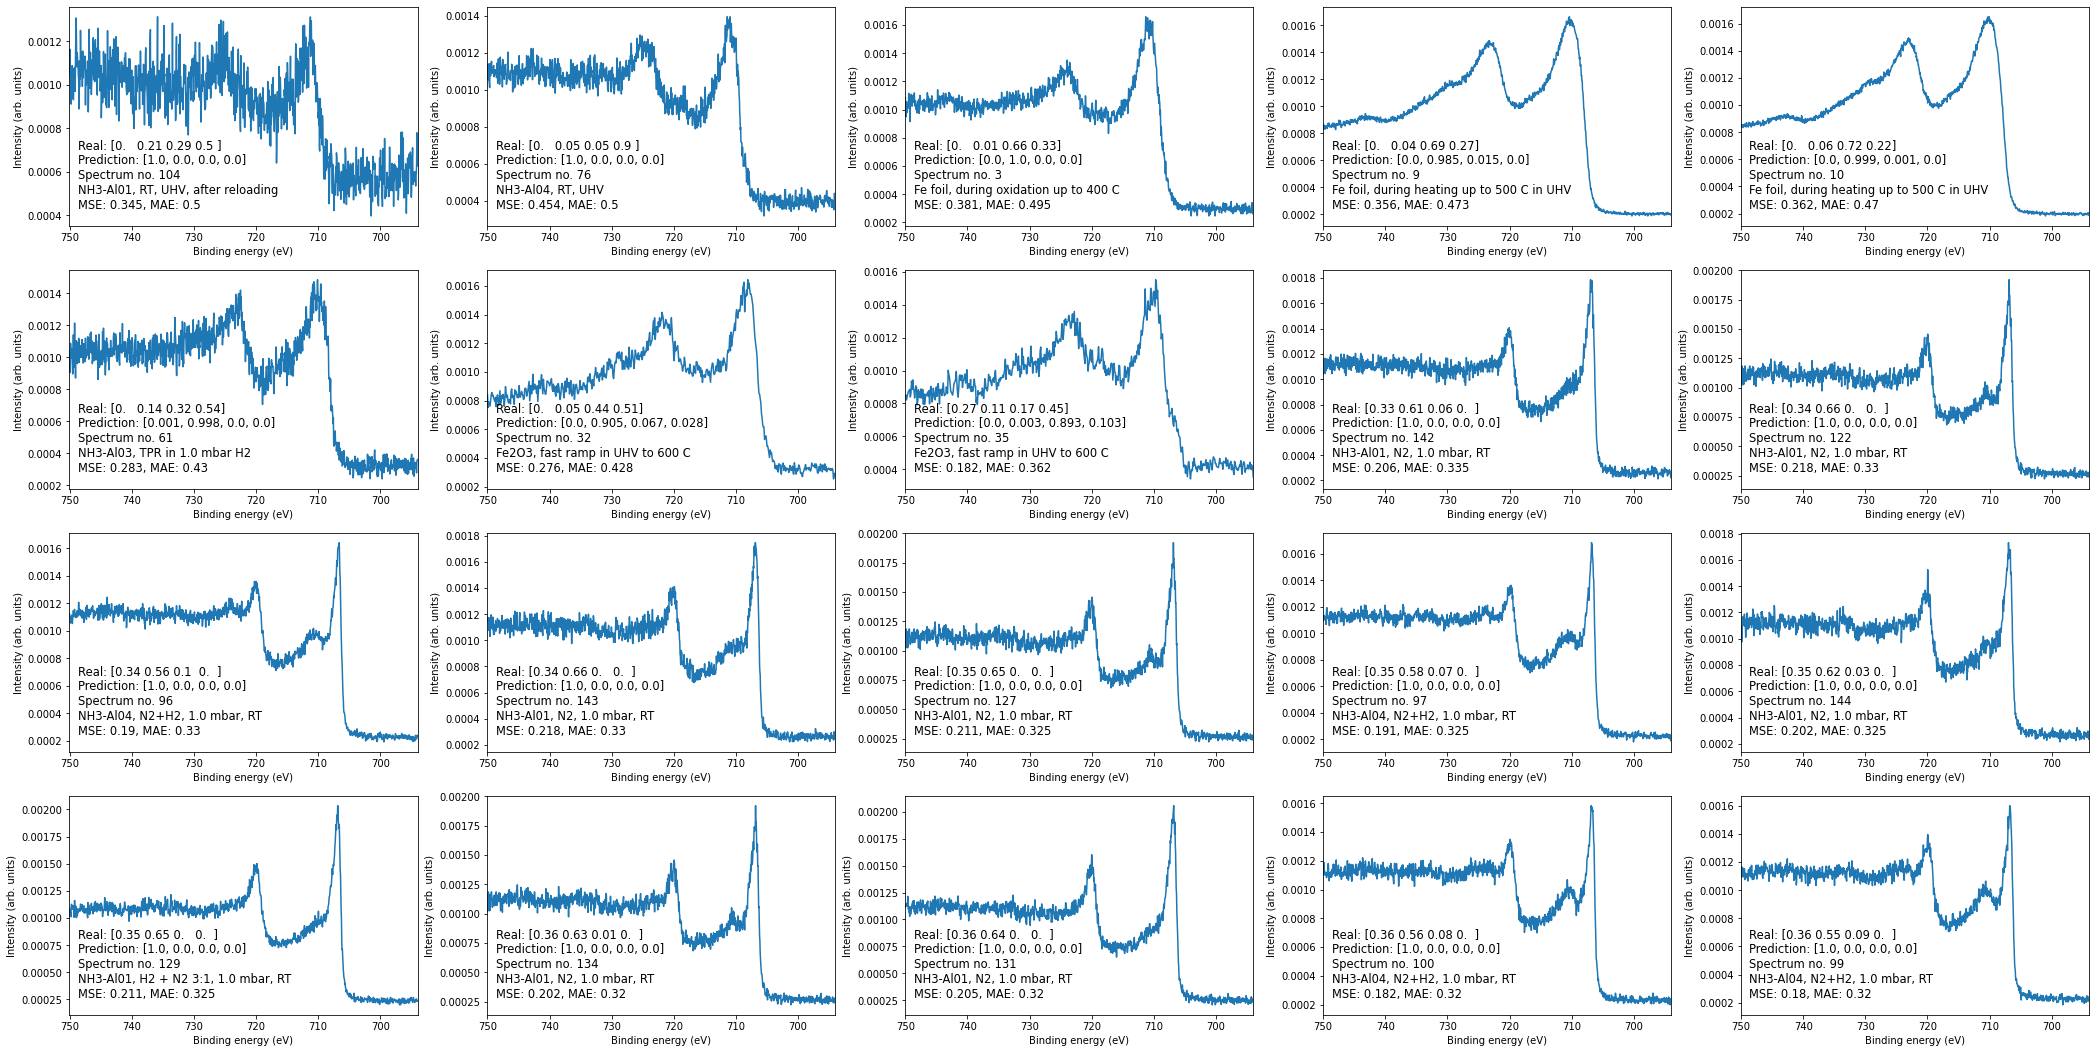

In [69]:
worst_indices_multiple = [j[1] for j in sorted([(x,i) for (i,x) in \
                          enumerate(mae_losses) if len(np.where(clf.y_test[i] == 0.)[0]) != 3],
                          reverse=True)] 
show_worst_of_one_kind(worst_indices_multiple, spectra = [0,20])

### Show worst predictions for different loss thresholds (linearly combined iron spectra)

34 of 145 test samples with multiple iron species (23.400000000000002%) have a mean absolute error of of at least 0.3.


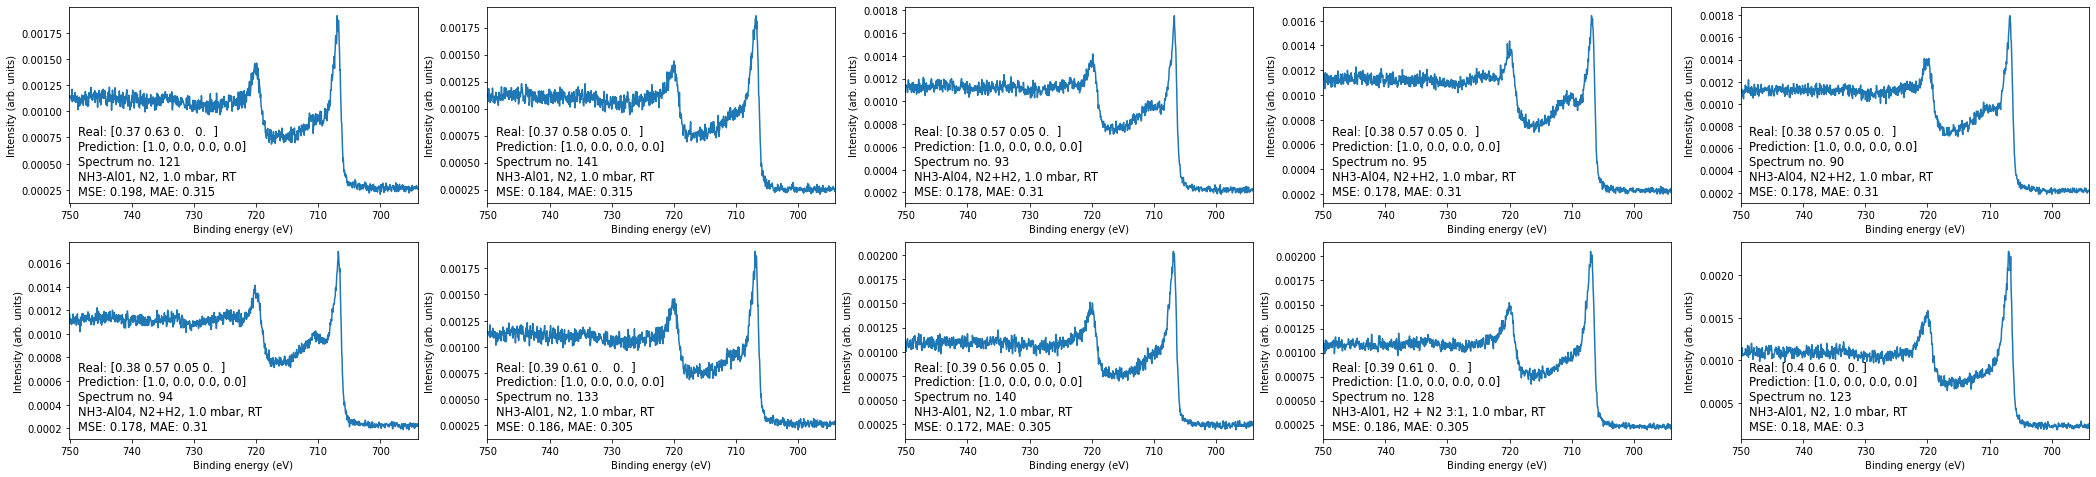

In [70]:
threshold = 0.3
worst_indices_multiple_01 = [j[1] for j in sorted([(x,i) for (i,x) in \
                             enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) != 3 and x >= threshold)],
                             reverse=True)]  
                                             
show_worst_of_one_kind(worst_indices_multiple_01,
                       spectra = [len(worst_indices_multiple_01)-10,
                                 len(worst_indices_multiple_01)])

print('{0} of {1} test samples with multiple iron species ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_multiple_01)),
    str(len(worst_indices_multiple)),
    str(100*(np.around(len(worst_indices_multiple_01)/len(worst_indices_multiple), decimals = 3))),
    str(threshold)))

67 of 145 test samples with multiple iron species (46.2%) have a mean absolute error of of at least 0.2.


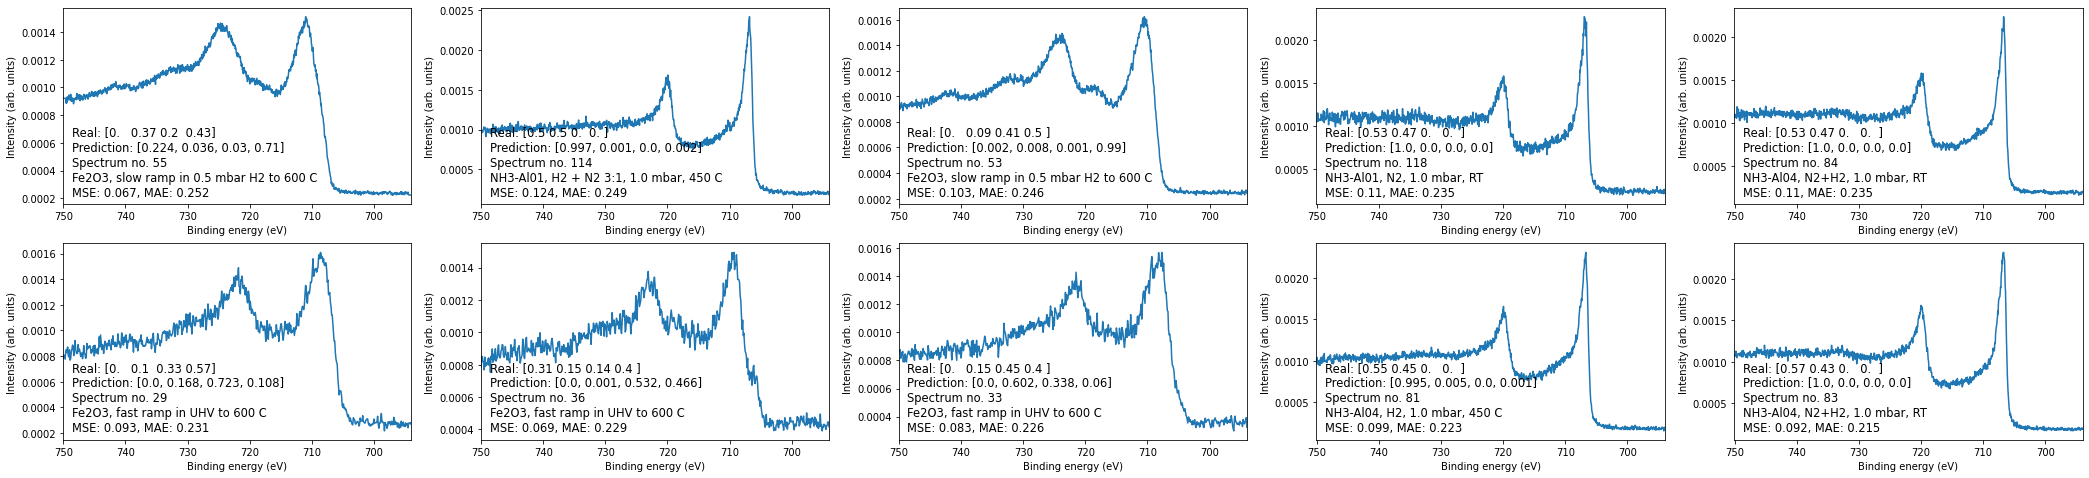

In [71]:
threshold = 0.2
worst_indices_multiple_02 = [j[1] for j in sorted([(x,i) for (i,x) in \
                            enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) != 3 and x >= threshold)],
                            reverse=True)]     

show_worst_of_one_kind(worst_indices_multiple_02,
                           spectra = [len(worst_indices_multiple_02)-10,
                                      len(worst_indices_multiple_02)])


print('{0} of {1} test samples with multiple iron species ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_multiple_02)),
    str(len(worst_indices_multiple)),
    str(100*(np.around(len(worst_indices_multiple_02)/len(worst_indices_multiple), decimals = 3))),
    str(threshold)))

109 of 145 test samples with multiple iron species (75.2%) have a mean absolute error of of at least 0.1.


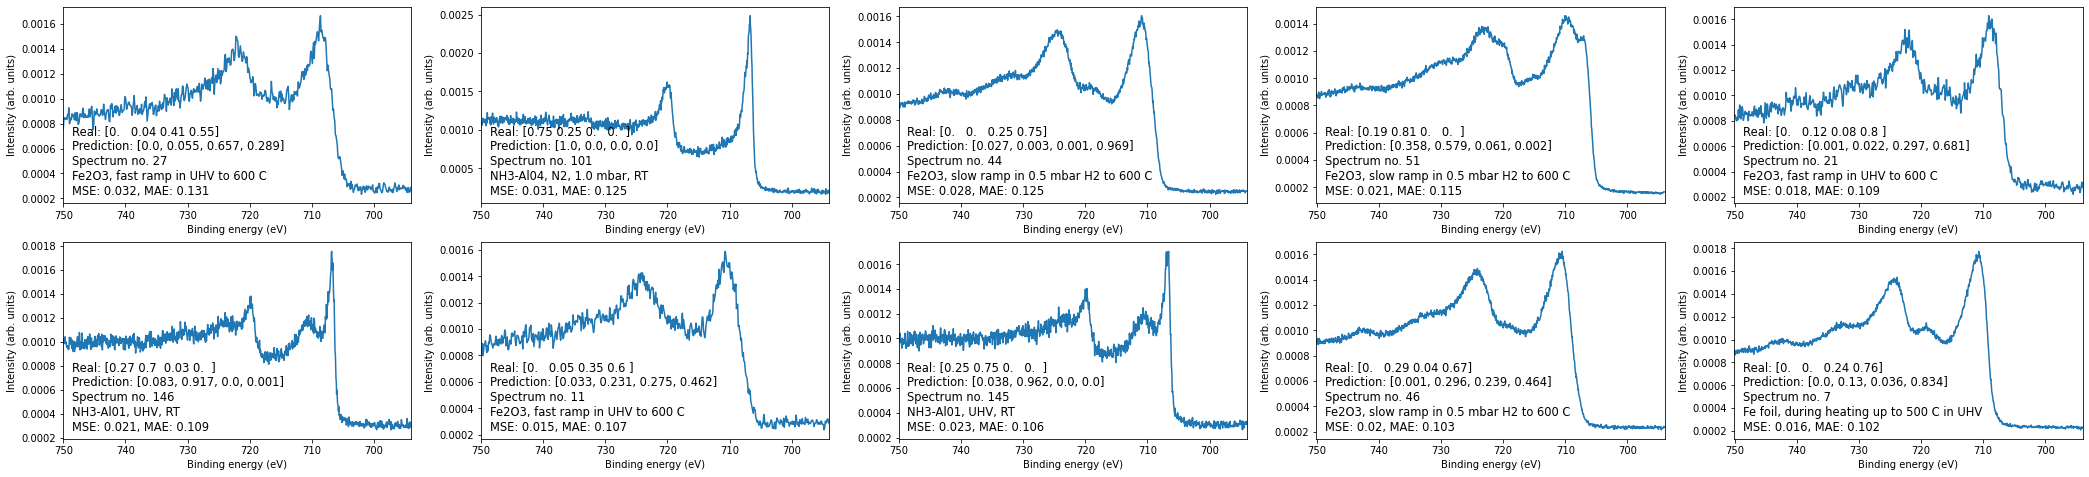

In [72]:
threshold = 0.1
worst_indices_multiple_03 = [j[1] for j in sorted([(x,i) for (i,x) in \
                             enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) != 3 and x >= threshold)],
                             reverse=True)]                  

if (len(worst_indices_multiple_03)) > 10:
    show_worst_of_one_kind(worst_indices_multiple_03,
                           spectra = [len(worst_indices_multiple_03)-10,
                                      len(worst_indices_multiple_03)])
else:
    show_worst_of_one_kind(worst_indices_multiple_03,
                           spectra = [0,
                                      len(worst_indices_multiple_03)])

print('{0} of {1} test samples with multiple iron species ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_multiple_03)),
    str(len(worst_indices_multiple)),
    str(100*(np.around(len(worst_indices_multiple_03)/len(worst_indices_multiple), decimals = 3))),
    str(threshold)))

126 of 145 test samples with multiple iron species (86.9%) have a mean absolute error of of at least 0.05.


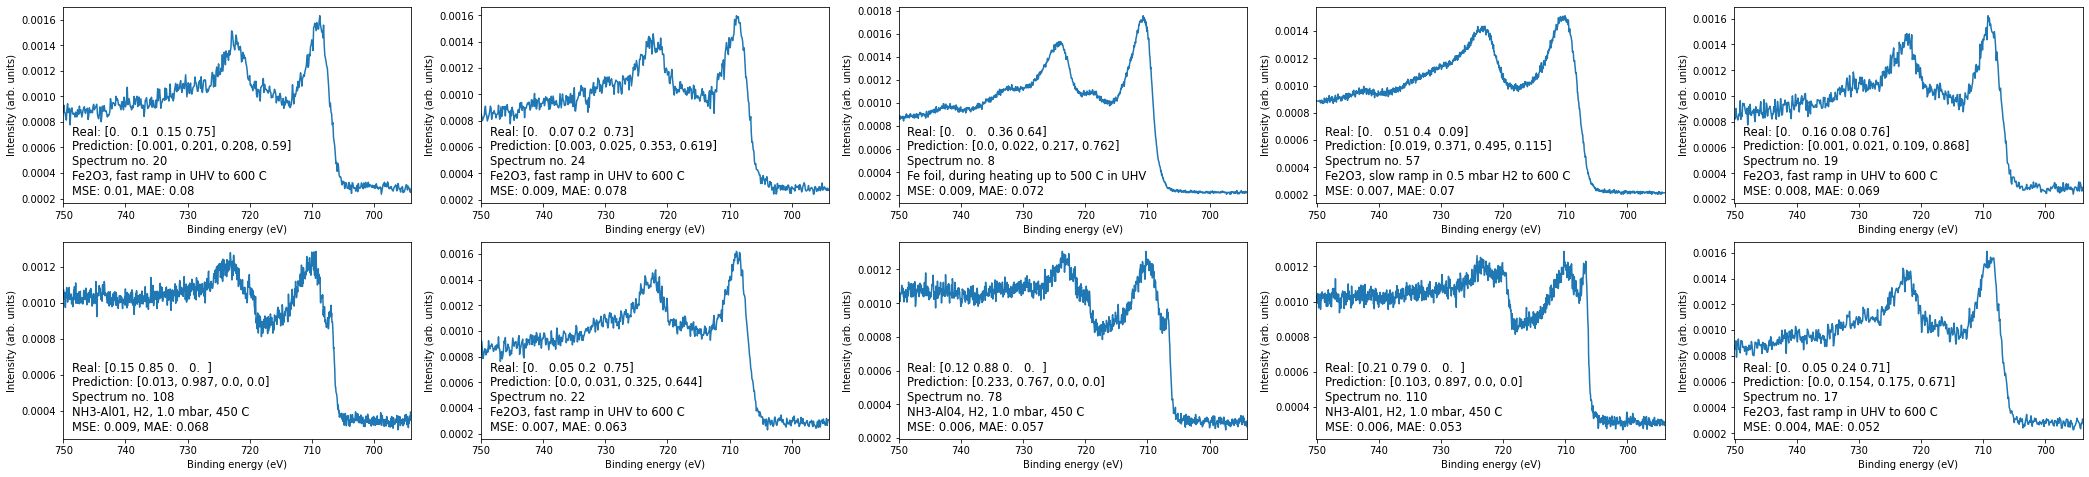

In [73]:
threshold = 0.05
worst_indices_multiple_04 = [j[1] for j in sorted([(x,i) for (i,x) in \
                             enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) != 3 and x >= threshold)],
                             reverse=True)]                  

if (len(worst_indices_multiple_04)) > 10:
    show_worst_of_one_kind(worst_indices_multiple_04,
                           spectra = [len(worst_indices_multiple_04)-10,
                                      len(worst_indices_multiple_04)])
else:
    show_worst_of_one_kind(worst_indices_multiple_04,
                           spectra = [0,
                                      len(worst_indices_multiple_04)])

print('{0} of {1} test samples with multiple iron species ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_multiple_04)),
    str(len(worst_indices_multiple)),
    str(100*(np.around(len(worst_indices_multiple_04)/len(worst_indices_multiple), decimals = 3))),
    str(threshold)))

140 of 145 test samples with multiple iron species (96.6%) have a mean absolute error of of at least 0.025.


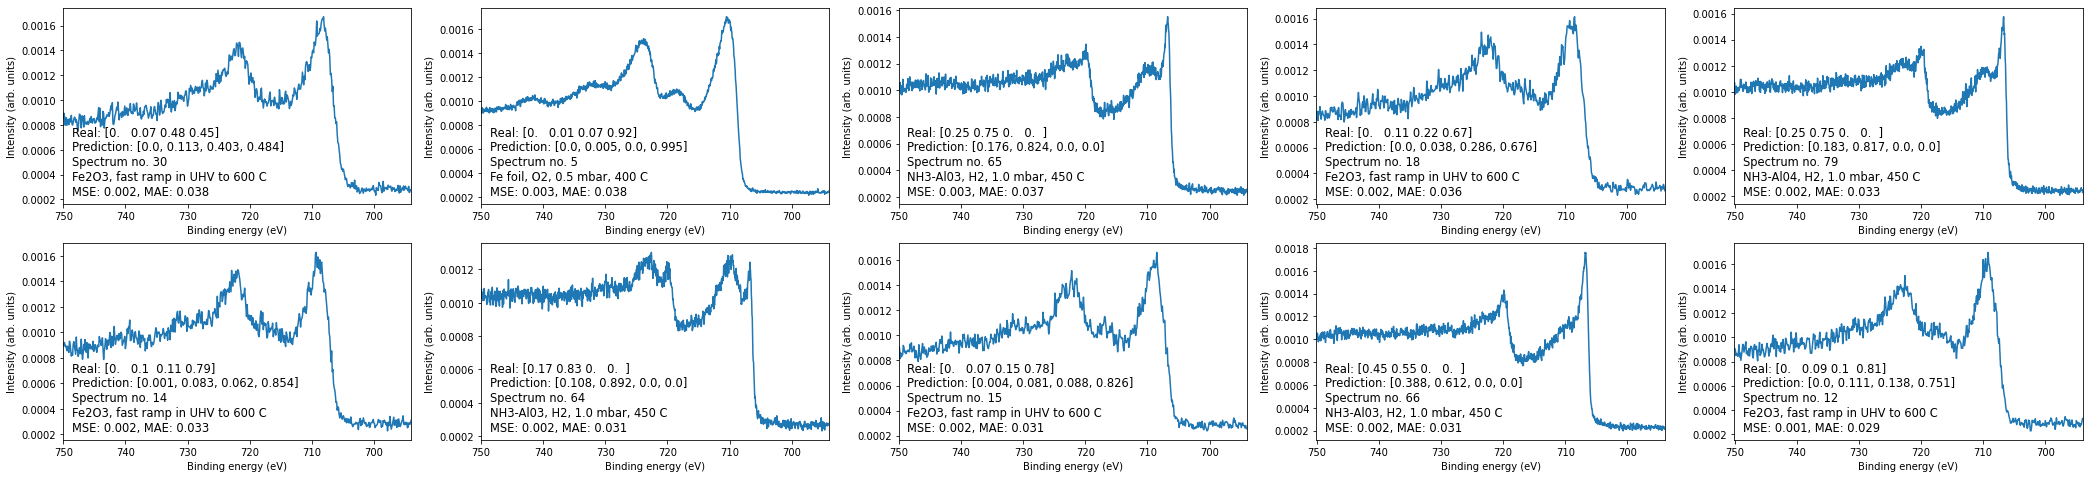

In [74]:
threshold = 0.025
worst_indices_multiple_05 = [j[1] for j in sorted([(x,i) for (i,x) in \
                             enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) != 3 and x >= threshold)],
                             reverse=True)]                  

if (len(worst_indices_multiple_05)) > 10:
    show_worst_of_one_kind(worst_indices_multiple_05,
                           spectra = [len(worst_indices_multiple_05)-10,
                                      len(worst_indices_multiple_05)])
else:
    show_worst_of_one_kind(worst_indices_multiple_05,
                           spectra = [0,
                                      len(worst_indices_multiple_05)])

print('{0} of {1} test samples with multiple iron species ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_multiple_05)),
    str(len(worst_indices_multiple)),
    str(100*(np.around(len(worst_indices_multiple_05)/len(worst_indices_multiple), decimals = 3))),
    str(threshold)))

144 of 145 test samples with multiple iron species (99.3%) have a mean absolute error of of at least 0.01.


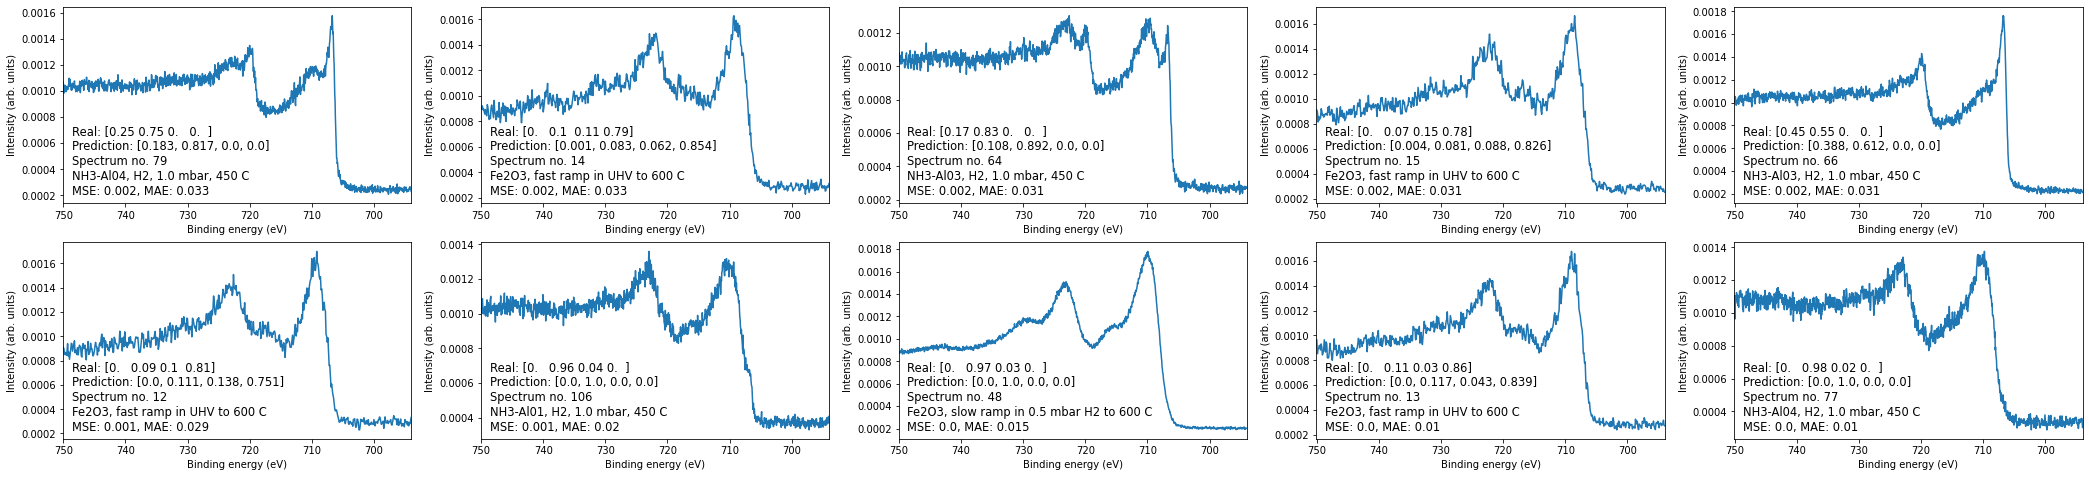

In [75]:
threshold = 0.01
worst_indices_multiple_06 = [j[1] for j in sorted([(x,i) for (i,x) in \
                             enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) != 3 and x >= threshold)],
                             reverse=True)]                  

if (len(worst_indices_multiple_06)) > 10:
    show_worst_of_one_kind(worst_indices_multiple_06,
                           spectra = [len(worst_indices_multiple_06)-10,
                                      len(worst_indices_multiple_06)])
else:
    show_worst_of_one_kind(worst_indices_multiple_06,
                           spectra = [0,
                                      len(worst_indices_multiple_06)])

print('{0} of {1} test samples with multiple iron species ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_multiple_06)),
    str(len(worst_indices_multiple)),
    str(100*(np.around(len(worst_indices_multiple_06)/len(worst_indices_multiple), decimals = 3))),
    str(threshold)))

### Show worst predictions for all

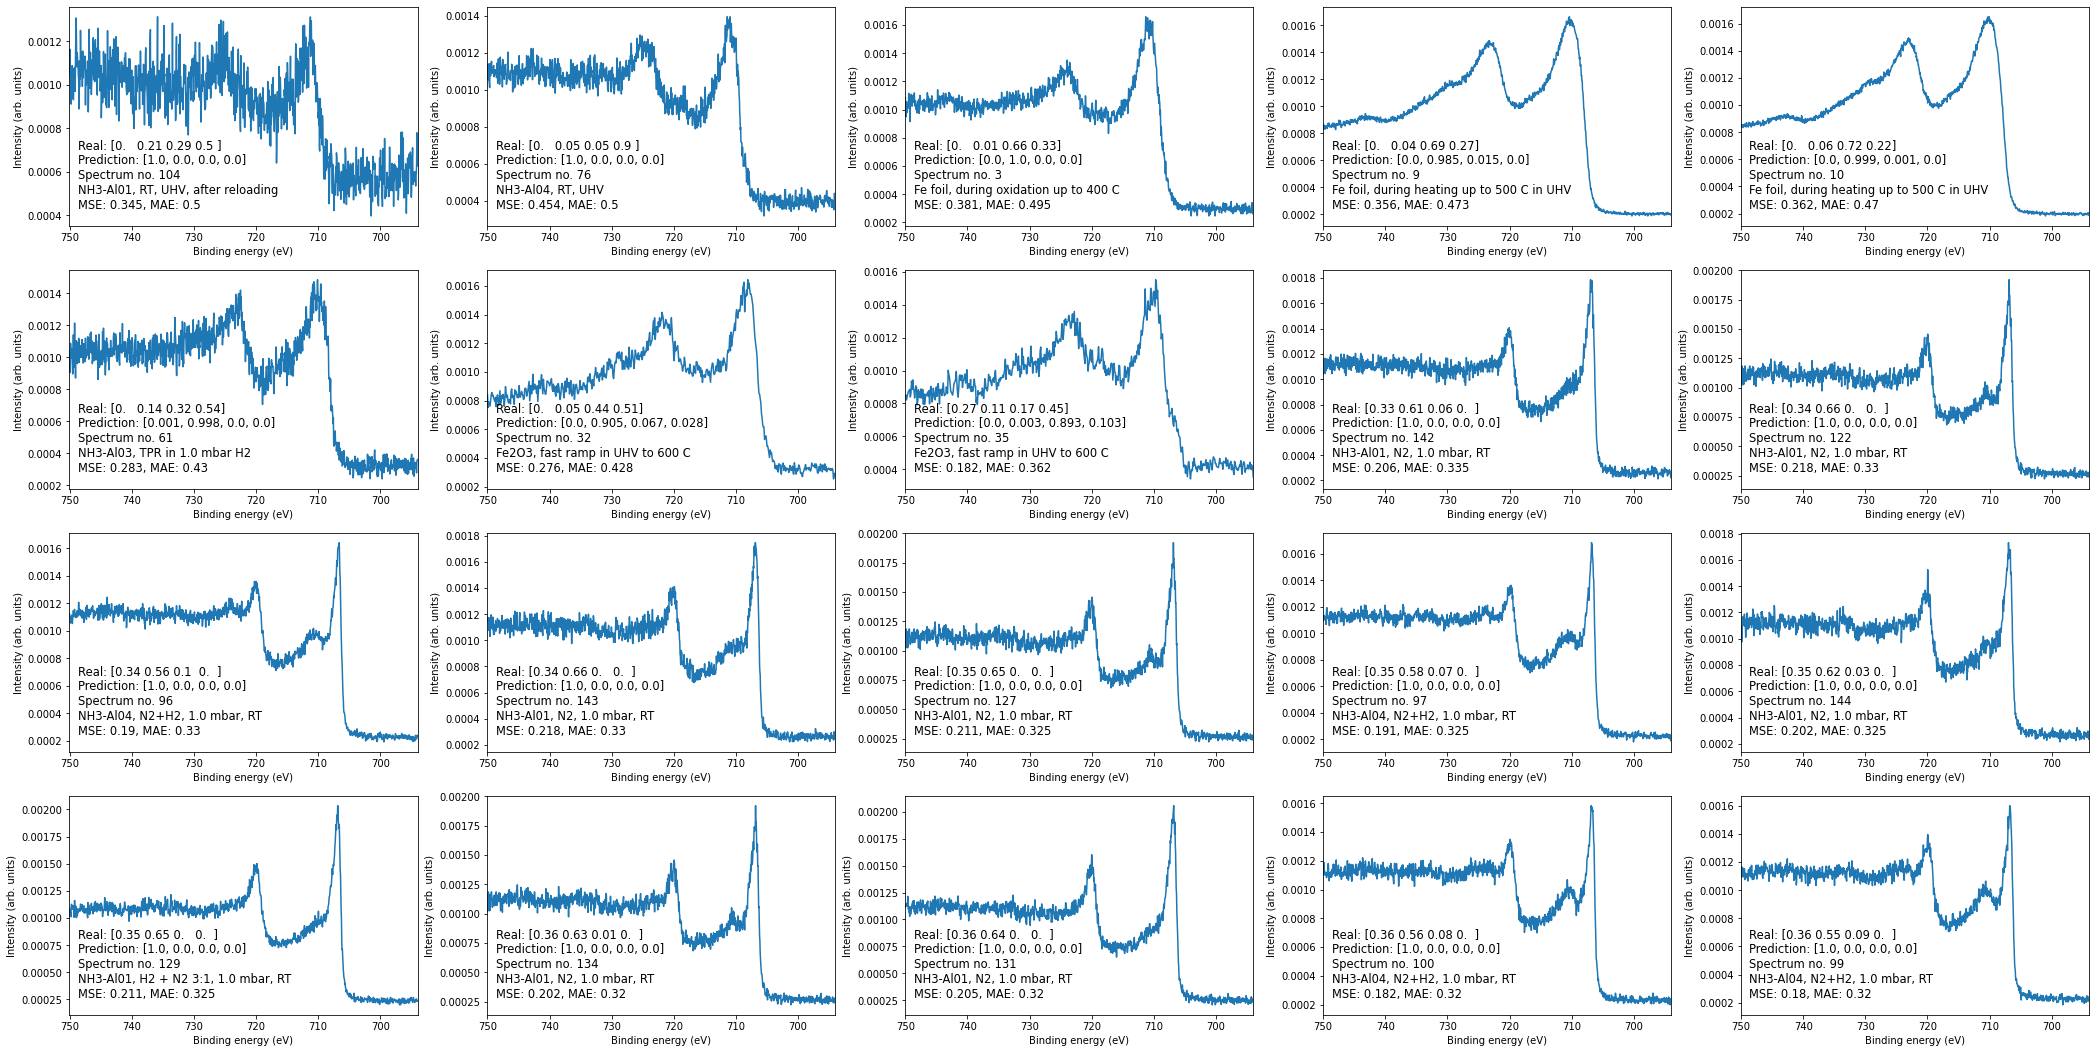

In [76]:
worst_indices = [j[1] for j in sorted([(x,i) for (i,x) in enumerate(mae_losses)],
                          reverse=True)] 
show_worst_of_one_kind(worst_indices, spectra = [0,20])

### Show worst predictions for different loss thresholds (linearly combined iron spectra)

34 of 155 test samples (21.9%) have a mean absolute error of of at least 0.3.


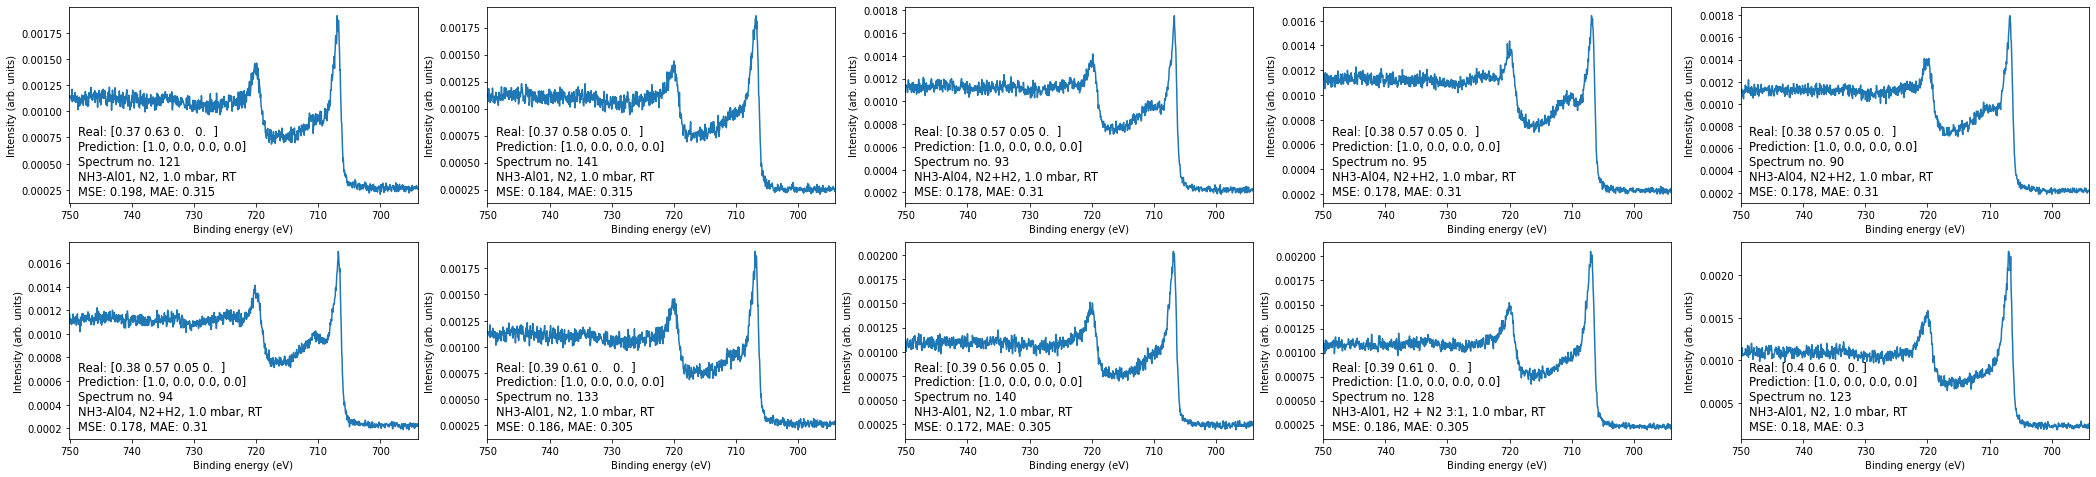

In [77]:
threshold = 0.3
worst_indices_01 = [j[1] for j in sorted([(x,i) for (i,x) in \
                                          enumerate(mae_losses) if x >= threshold],
                             reverse=True)]  
                                             
show_worst_of_one_kind(worst_indices_01,
                       spectra = [len(worst_indices_01)-10,
                                  len(worst_indices_01)])

print('{0} of {1} test samples ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_01)),
    str(len(worst_indices)),
    str(100*(np.around(len(worst_indices_01)/len(worst_indices), decimals = 3))),
    str(threshold)))

67 of 155 test samples (43.2%) have a mean absolute error of of at least 0.2.


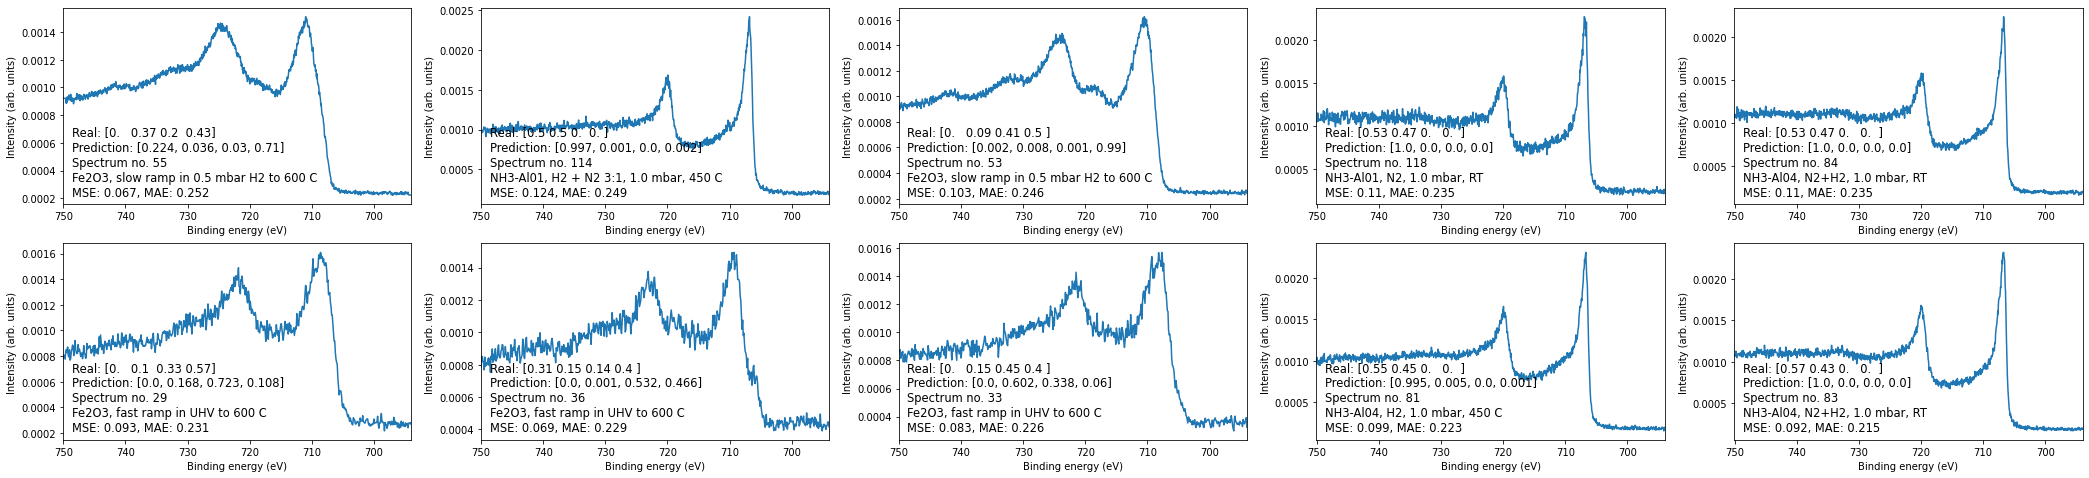

In [78]:
threshold = 0.2
worst_indices_02 = [j[1] for j in sorted([(x,i) for (i,x) in \
                                          enumerate(mae_losses) if x >= threshold],
                             reverse=True)]  
                                             
show_worst_of_one_kind(worst_indices_02,
                       spectra = [len(worst_indices_02)-10,
                                  len(worst_indices_02)])

print('{0} of {1} test samples ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_02)),
    str(len(worst_indices)),
    str(100*(np.around(len(worst_indices_02)/len(worst_indices), decimals = 3))),
    str(threshold)))

109 of 145 test samples (75.2%) have a mean absolute error of of at least 0.1.


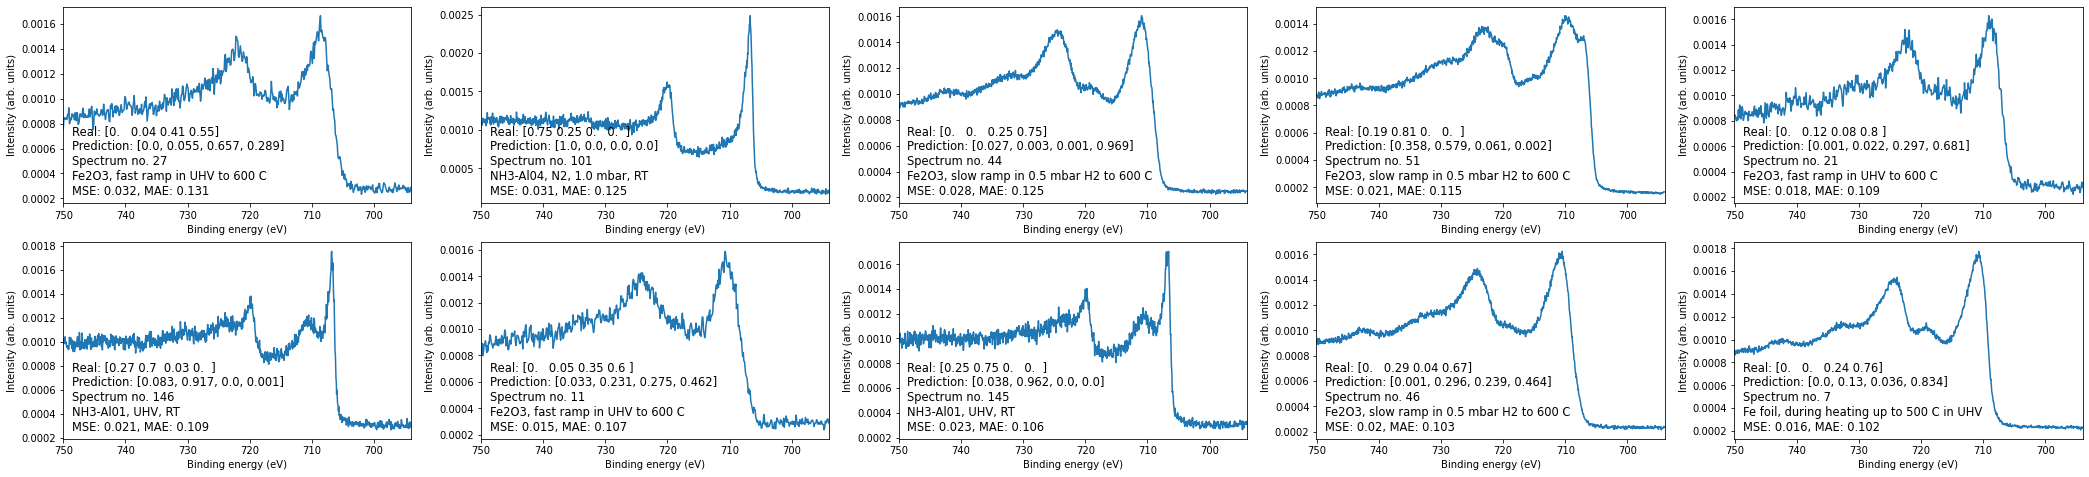

In [80]:
threshold = 0.1
worst_indices_multiple_03 = [j[1] for j in sorted([(x,i) for (i,x) in \
                             enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) != 3 and x >= threshold)],
                             reverse=True)]                  

if (len(worst_indices_multiple_03)) > 10:
    show_worst_of_one_kind(worst_indices_multiple_03,
                           spectra = [len(worst_indices_multiple_03)-10,
                                      len(worst_indices_multiple_03)])
else:
    show_worst_of_one_kind(worst_indices_multiple_03,
                           spectra = [0,
                                      len(worst_indices_multiple_03)])

print('{0} of {1} test samples ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_multiple_03)),
    str(len(worst_indices_multiple)),
    str(100*(np.around(len(worst_indices_multiple_03)/len(worst_indices_multiple), decimals = 3))),
    str(threshold)))

126 of 145 test samples (86.9%) have a mean absolute error of of at least 0.05.


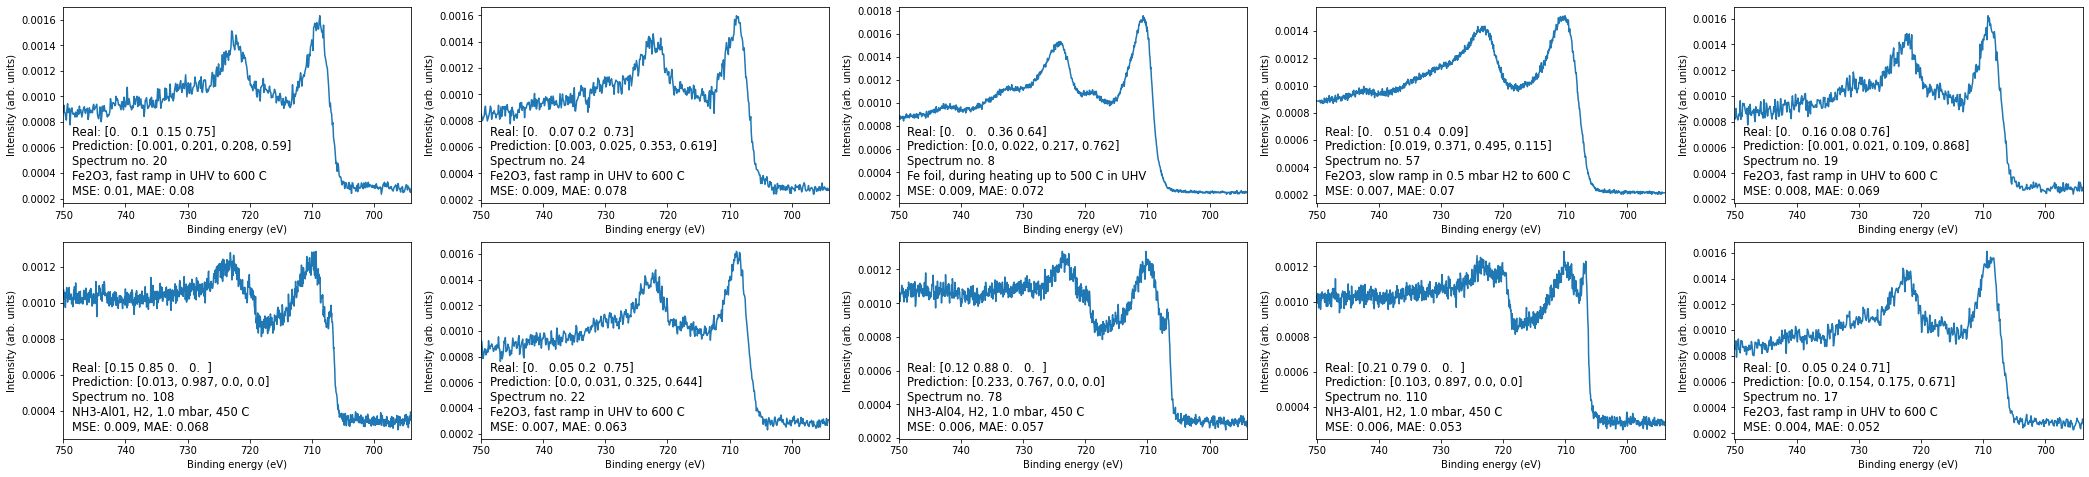

In [81]:
threshold = 0.05
worst_indices_multiple_04 = [j[1] for j in sorted([(x,i) for (i,x) in \
                             enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) != 3 and x >= threshold)],
                             reverse=True)]                  

if (len(worst_indices_multiple_04)) > 10:
    show_worst_of_one_kind(worst_indices_multiple_04,
                           spectra = [len(worst_indices_multiple_04)-10,
                                      len(worst_indices_multiple_04)])
else:
    show_worst_of_one_kind(worst_indices_multiple_04,
                           spectra = [0,
                                      len(worst_indices_multiple_04)])

print('{0} of {1} test samples ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_multiple_04)),
    str(len(worst_indices_multiple)),
    str(100*(np.around(len(worst_indices_multiple_04)/len(worst_indices_multiple), decimals = 3))),
    str(threshold)))

140 of 145 test samples (96.6%) have a mean absolute error of of at least 0.025.


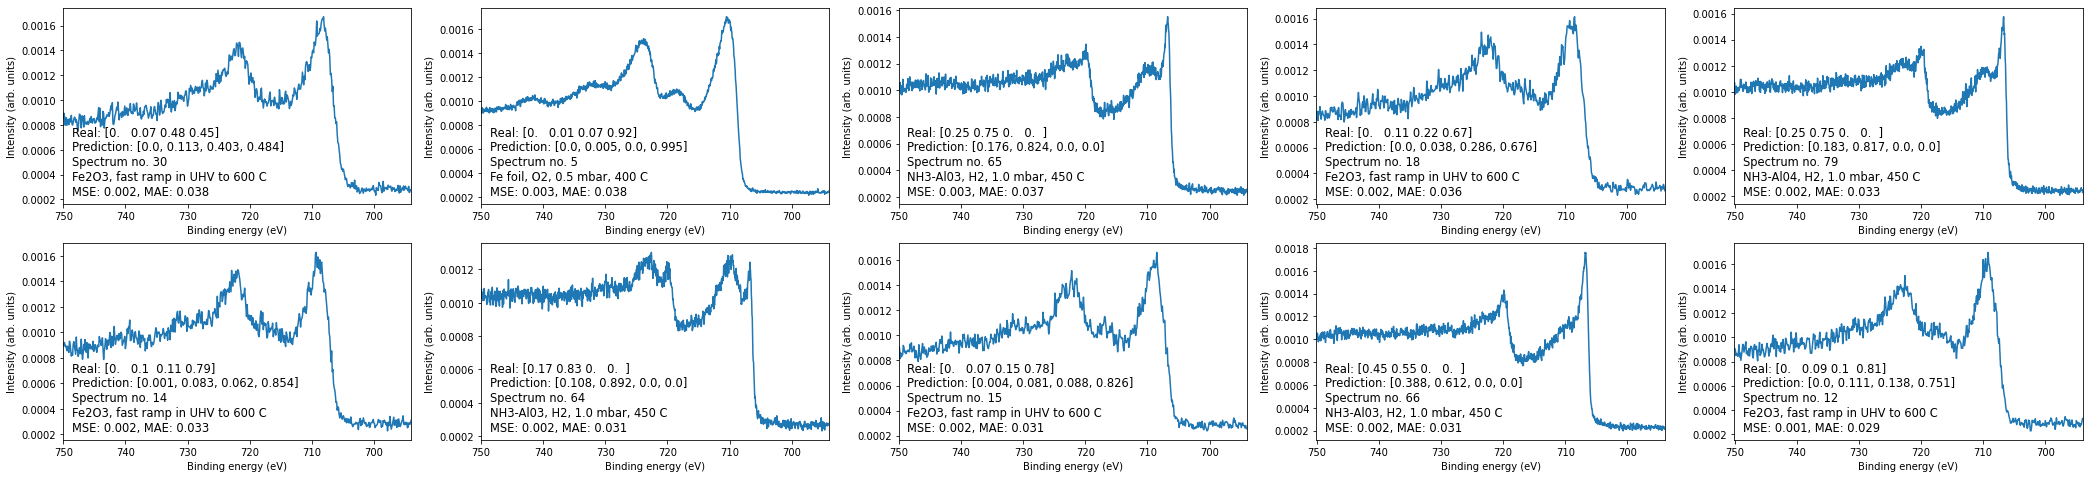

In [82]:
threshold = 0.025
worst_indices_multiple_05 = [j[1] for j in sorted([(x,i) for (i,x) in \
                             enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) != 3 and x >= threshold)],
                             reverse=True)]                  

if (len(worst_indices_multiple_05)) > 10:
    show_worst_of_one_kind(worst_indices_multiple_05,
                           spectra = [len(worst_indices_multiple_05)-10,
                                      len(worst_indices_multiple_05)])
else:
    show_worst_of_one_kind(worst_indices_multiple_05,
                           spectra = [0,
                                      len(worst_indices_multiple_05)])

print('{0} of {1} test samples ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_multiple_05)),
    str(len(worst_indices_multiple)),
    str(100*(np.around(len(worst_indices_multiple_05)/len(worst_indices_multiple), decimals = 3))),
    str(threshold)))

144 of 145 test samples with multiple iron species (99.3%) have a mean absolute error of of at least 0.01.


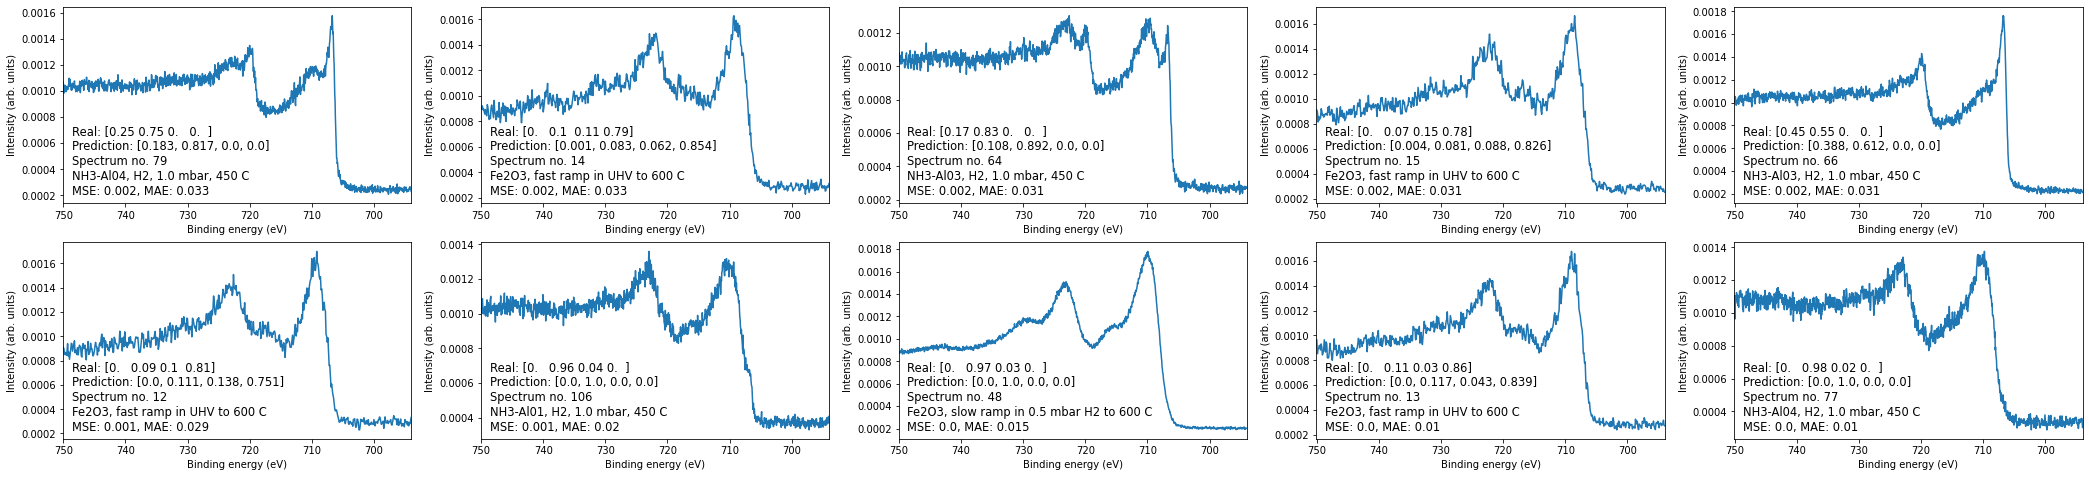

In [83]:
threshold = 0.01
worst_indices_multiple_06 = [j[1] for j in sorted([(x,i) for (i,x) in \
                             enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) != 3 and x >= threshold)],
                             reverse=True)]                  

if (len(worst_indices_multiple_06)) > 10:
    show_worst_of_one_kind(worst_indices_multiple_06,
                           spectra = [len(worst_indices_multiple_06)-10,
                                      len(worst_indices_multiple_06)])
else:
    show_worst_of_one_kind(worst_indices_multiple_06,
                           spectra = [0,
                                      len(worst_indices_multiple_06)])

print('{0} of {1} test samples with multiple iron species ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_multiple_06)),
    str(len(worst_indices_multiple)),
    str(100*(np.around(len(worst_indices_multiple_06)/len(worst_indices_multiple), decimals = 3))),
    str(threshold)))

## Save output of notebook

In [86]:
from IPython.display import Javascript, display
from nbconvert import HTMLExporter

def save_notebook():
    display(Javascript("IPython.notebook.save_notebook()"),
            include=['application/javascript'])

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

import time
import os

time.sleep(20)
save_notebook()
print('Notebook saved!')
time.sleep(30)
current_file = '/content/drive/My Drive/app/xpsdeeplearning/predict_unknown_multiple.ipynb'
output_file = os.path.join(clf.log_dir,'predict_unknown_multiple_out.html')
output_HTML(current_file, output_file)
print('HTML file saved!')

Notebook saved!
HTML file saved!
